<a href="https://colab.research.google.com/github/Applied-Machine-Learning-2022/final-project-jep-ua/blob/main/Capstone_Jep_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract==0.3.9 
!pip install imutils
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/wzh191920/License-Plate-Recognition License-Plate-Recognition-master

Cloning into 'License-Plate-Recognition-master'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 107 (delta 45), reused 99 (delta 43), pack-reused 1
Receiving objects: 100% (107/107), 16.11 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [4]:
import zipfile
import os

with zipfile.ZipFile('License-Plate-Recognition-master','r') as z:
  z.extractall('./')

os.listdir()

IsADirectoryError: ignored

In [ ]:
# installing pytorch prebuilt
! pip install torch==1.6.0 torchvision==0.7.0
 
# install mmcv (computer vision based library)
! pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.6.0/index.html
 
# now below install mmdet, mmocr
! pip install mmdet
 
! git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
! pip install -r requirements.txt
! pip install -v -e . 
 
!export PYTHONPATH=$(pwd):$PYTHONPATH

In [ ]:
! pip install mmocr

In [ ]:
from mmocr.utils.ocr import MMOCR

len(contours) 0
len(contours) 0
len(contours) 0
len(contours) 0
len(contours) 0
len(contours) 0
len(contours) 2
len(contours) 2
len(contours) 2
len(contours) 2
len(contours) 2
len(contours) 1
len(contours) 1
len(contours) 3


a” #2}?



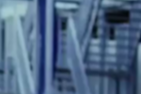

es

len(contours) 3


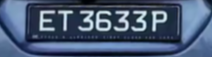

ET 3633P J



ai is”



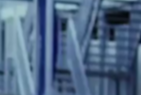

Rites

len(contours) 3


aie is”



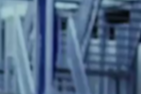

es

len(contours) 3


aie is”



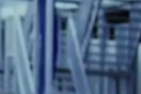

es

len(contours) 3


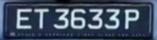

PakiKkio



aig is?



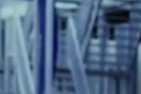

es

len(contours) 4


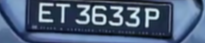

\ BAEK /



aie is”



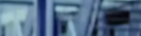

CULL

len(contours) 4


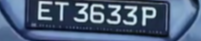

\ BEEK /



aie is?



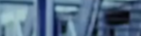

ina

len(contours) 4


fa ixXk1



aise is?”



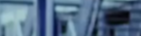

ira

len(contours) 4


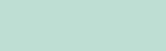

OO



a’ if i}

len(contours) 4


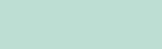

OO



aie it?



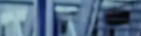

mi

len(contours) 3


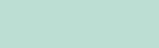

OO



a if it’

len(contours) 3


aie it?



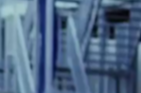

hes

len(contours) 3


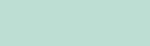

OO



aie it?



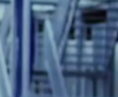

H Nee

len(contours) 3


aig it

len(contours) 3


aie it

len(contours) 3


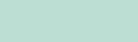

OO



aie it?

len(contours) 3


aie it

len(contours) 3


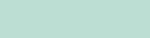

OO



aie is’

len(contours) 3


@” #2 ,}'



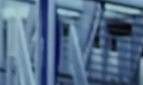

es

len(contours) 3


a Zé it'



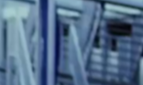

es

len(contours) 3


NEE id /



aise is’

len(contours) 3


tte



@” #é ,}'



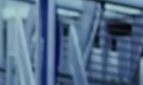

es

len(contours) 3


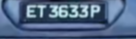

eed

len(contours) 3


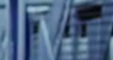

oe

len(contours) 3


——_._

len(contours) 1


oer eel

len(contours) 1


——

len(contours) 1
len(contours) 1


oe pes

len(contours) 1
len(contours) 1


—— ee

len(contours) 0
len(contours) 1


——— ee

len(contours) 1


-) 22>: -

len(contours) 1


ee he

len(contours) 1


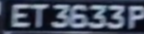

ET3633P

len(contours) 1
len(contours) 1


ce

len(contours) 1


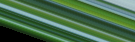

—<—S=

len(contours) 1


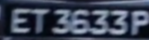

36-1.

len(contours) 1


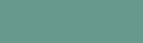

—_

len(contours) 1


Bei.

len(contours) 1


ci S5055F

len(contours) 1


ci SO55F



KeyboardInterrupt: ignored

In [1]:
#Final Code
from PIL import Image
import PIL
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt
import urllib.request
import os
import tarfile
import shutil
import tensorflow as tf
from numpy.linalg import norm
import sys
import  os
import json
from google.colab.patches import cv2_imshow
# from mmocr.utils.ocr import MMOCR


SZ  =  20           #training picture length and width
MAX_WIDTH  =  1000 #Original  image maximum width
Min_Area  =  2000 #The   maximum allowable area of ​​the license plate area
PROVINCE_START = 1000


base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

os.listdir()

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
  shutil.rmtree(dir_name) 

tarfile.open(file_name, 'r:gz').extractall('./')

os.listdir(dir_name)

frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.io.gfile.GFile(frozen_graph, "rb") as f:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(f.read())

cars_video = cv2.VideoCapture('/content/Mercedes Glk - 1406.mp4')
height = int(cars_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cars_video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cars_video.get(cv2.CAP_PROP_FPS)
total_frames = int(cars_video.get(cv2.CAP_PROP_FRAME_COUNT))

frames_read = 0

r = 255
g = 0
b = 0
scale = .5
thickness = 1

outputs = (
  'num_detections:0',
  'detection_classes:0',
  'detection_scores:0',
  'detection_boxes:0',
)

def wrap_graph(graph_def, inputs, outputs, print_graph=False):
  wrapped = tf.compat.v1.wrap_function(
    lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])

  return wrapped.prune(
    tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
    tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))


model = wrap_graph(graph_def=graph_def,
                   inputs=["image_tensor:0"],
                   outputs=outputs)
model.outputs


def point_limit(point):
    if point[0] < 0:
        point[0] = 0
    if point[1] < 0:
        point[1] = 0


def accurate_place(card_img_hsv, limit1, limit2, color):
    row_num, col_num = card_img_hsv.shape[:2]
    xl = col_num
    xr = 0
    yh = 0
    yl = row_num
    #col_num_limit = self.cfg["col_num_limit"]
    row_num_limit = 18
    col_num_limit = col_num * 0.8 if color != "green" else col_num * 0.5#绿色有渐变
    for i in range(row_num):
        count = 0
        for j in range(col_num):
            H = card_img_hsv.item(i, j, 0)
            S = card_img_hsv.item(i, j, 1)
            V = card_img_hsv.item(i, j, 2)
            if limit1 < H <= limit2 and 34 < S and 46 < V:
                count += 1
        if count > col_num_limit:
            if yl > i:
                yl = i
            if yh < i:
                yh = i
    for j in range(col_num):
        count = 0
        for i in range(row_num):
            H = card_img_hsv.item(i, j, 0)
            S = card_img_hsv.item(i, j, 1)
            V = card_img_hsv.item(i, j, 2)
            if limit1 < H <= limit2 and 34 < S and 46 < V:
                count += 1
        if count > row_num - row_num_limit:
            if xl > j:
                xl = j
            if xr < j:
                xr = j
    return xl, xr, yh, yl


fourcc = cv2.VideoWriter_fourcc(*'mp4v')

for i in range(0, int(cars_video.get(cv2.CAP_PROP_FRAME_COUNT))):
  cars_video.set(cv2.CAP_PROP_POS_FRAMES, i)
  ret, img = cars_video.read()
  # img = cv2.imread("/content/License-Plate-Recognition-master/test/car5.jpg")
  if (not ret):
    break 
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # cv2_imshow(img)
  h, w,_ = img.shape
  input_images = [img]
  tensor = tf.convert_to_tensor(input_images, dtype=tf.uint8)

  detections = model(tensor)
  # print(detections)
  # for i, box in enumerate(detections[3][0]):
  # print(detections[1][0])
  if len([i for i in detections[1][0] if i == 3]):
    # img = cv2.imread("/content/Corvette.jpeg")
    pic_hight, pic_width = img.shape[:2]
    if pic_width > MAX_WIDTH:
        pic_rate = MAX_WIDTH / pic_width
        img = cv2.resize(img, (MAX_WIDTH, int(pic_hight*pic_rate)), interpolation=cv2.INTER_LANCZOS4)

    # print("h,w:", pic_hight, pic_width)
    blur = 3
    #高斯去噪
    if blur > 0:
        img = cv2.GaussianBlur(img, (blur, blur), 0)#图片分辨率调整
    oldimg = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((20, 20), np.uint8)
    img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img_opening = cv2.addWeighted(img, 1, img_opening, -1, 0);

    #找到图像边缘
    ret, img_thresh = cv2.threshold(img_opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_edge = cv2.Canny(img_thresh, 100, 200)
    #使用开运算和闭运算让图像边缘成为一个整体
    kernel = np.ones((5, 12), np.uint8)
    img_edge1 = cv2.morphologyEx(img_edge, cv2.MORPH_CLOSE, kernel)
    img_edge2 = cv2.morphologyEx(img_edge1, cv2.MORPH_OPEN, kernel)

    #查找图像边缘整体形成的矩形区域，可能有很多，车牌就在其中一个矩形区域中
    try:
        contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except ValueError:
        image, contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > Min_Area]
    # print('len(contours)', len(contours))
    #一一排除不是车牌的矩形区域
    car_contours = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        area_width, area_height = rect[1]
        if area_width < area_height:
            area_width, area_height = area_height, area_width
        wh_ratio = area_width / area_height
        #print(wh_ratio)
        #要求矩形区域长宽比在2到5.5之间，2到5.5是车牌的长宽比，其余的矩形排除
        if wh_ratio > 0 and wh_ratio < 6: #2 and 5.5
            car_contours.append(rect)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            #oldimg = cv2.drawContours(oldimg, [box], 0, (0, 0, 255), 2)
            #cv2.imshow("edge4", oldimg)
            #cv2.waitKey(0)

    print('len(contours)', len(car_contours))

    # print("精确定位")
    card_imgs = []
    #矩形区域可能是倾斜的矩形，需要矫正，以便使用颜色定位
    for rect in car_contours:
        if rect[2] > -1 and rect[2] < 1:#创造角度，使得左、高、右、低拿到正确的值
            angle = 1
        else:
            angle = rect[2]
        rect = (rect[0], (rect[1][0]+5, rect[1][1]+5), angle)#扩大范围，避免车牌边缘被排除

        box = cv2.boxPoints(rect)
        heigth_point = right_point = [0, 0]
        left_point = low_point = [pic_width, pic_hight]
        for point in box:
            if left_point[0] > point[0]:
                left_point = point
            if low_point[1] > point[1]:
                low_point = point
            if heigth_point[1] < point[1]:
                heigth_point = point
            if right_point[0] < point[0]:
                right_point = point

        if left_point[1] <= right_point[1]:#正角度
            new_right_point = [right_point[0], heigth_point[1]]
            pts2 = np.float32([left_point, heigth_point, new_right_point])#字符只是高度需要改变
            pts1 = np.float32([left_point, heigth_point, right_point])
            M = cv2.getAffineTransform(pts1, pts2)
            dst = cv2.warpAffine(oldimg, M, (pic_width, pic_hight))
            point_limit(new_right_point)
            point_limit(heigth_point)
            point_limit(left_point)
            card_img = dst[int(left_point[1]):int(heigth_point[1]), int(left_point[0]):int(new_right_point[0])]
            card_imgs.append(card_img)
            #cv2.imshow("card", card_img)
            #cv2.waitKey(0)
        elif left_point[1] > right_point[1]:#负角度
            
            new_left_point = [left_point[0], heigth_point[1]]
            pts2 = np.float32([new_left_point, heigth_point, right_point])#字符只是高度需要改变
            pts1 = np.float32([left_point, heigth_point, right_point])
            M = cv2.getAffineTransform(pts1, pts2)
            dst = cv2.warpAffine(oldimg, M, (pic_width, pic_hight))
            point_limit(right_point)
            point_limit(heigth_point)
            point_limit(new_left_point)
            card_img = dst[int(right_point[1]):int(heigth_point[1]), int(new_left_point[0]):int(right_point[0])]
            card_imgs.append(card_img)
            #cv2.imshow("card", card_img)
            #cv2.waitKey(0)
    #开始使用颜色定位，排除不是车牌的矩形，目前只识别蓝、绿、黄车牌
    colors = []
    for card_index,card_img in enumerate(card_imgs):
        green = yello = blue = black = white = 0
        card_img_hsv = cv2.cvtColor(card_img, cv2.COLOR_BGR2HSV)
        #有转换失败的可能，原因来自于上面矫正矩形出错
        if card_img_hsv is None:
            continue
        row_num, col_num= card_img_hsv.shape[:2]
        card_img_count = row_num * col_num

        for i in range(row_num):
            for j in range(col_num):
                H = card_img_hsv.item(i, j, 0)
                S = card_img_hsv.item(i, j, 1)
                V = card_img_hsv.item(i, j, 2)
                if 11 < H <= 34 and S > 34:#图片分辨率调整
                    yello += 1
                elif 35 < H <= 99 and S > 34:#图片分辨率调整
                    green += 1
                elif 99 < H <= 124 and S > 34:#图片分辨率调整
                    blue += 1
                
                if 0 < H <180 and 0 < S < 255 and 0 < V < 46:
                    black += 1
                elif 0 < H <180 and 0 < S < 43 and 221 < V < 225:
                    white += 1
        color = "no"

        limit1 = limit2 = 0
        if yello*2 >= card_img_count:
            color = "yello"
            limit1 = 11
            limit2 = 34#有的图片有色偏偏绿
        elif green*2 >= card_img_count:
            color = "green"
            limit1 = 35
            limit2 = 99
        elif blue*2 >= card_img_count:
            color = "blue"
            limit1 = 100
            limit2 = 124#有的图片有色偏偏紫
        elif black + white >= card_img_count*0.7:#TODO
            color = "bw"
        # print(color)
        colors.append(color)
        # print(blue, green, yello, black, white, card_img_count)
        #cv2.imshow("color", card_img)
        #cv2.waitKey(0)
        if limit1 == 0:
            continue
        #以上为确定车牌颜色
        #以下为根据车牌颜色再定位，缩小边缘非车牌边界
        xl, xr, yh, yl = accurate_place(card_img_hsv, limit1, limit2, color)
        if yl == yh and xl == xr:
            continue
        need_accurate = False
        if yl >= yh:
            yl = 0
            yh = row_num
            need_accurate = True
        if xl >= xr:
            xl = 0
            xr = col_num
            need_accurate = True
        card_imgs[card_index] = card_img[yl:yh, xl:xr] if color != "green" or yl < (yh-yl)//4 else card_img[yl-(yh-yl)//4:yh, xl:xr]
        if need_accurate:#可能x或y方向未缩小，需要再试一次
            card_img = card_imgs[card_index]
            card_img_hsv = cv2.cvtColor(card_img, cv2.COLOR_BGR2HSV)
            xl, xr, yh, yl = accurate_place(card_img_hsv, limit1, limit2, color)
            if yl == yh and xl == xr:
                continue
            if yl >= yh:
                yl = 0
                yh = row_num
            if xl >= xr:
                xl = 0
                xr = col_num
        card_imgs[card_index] = card_img[yl:yh, xl:xr] if color != "green" or yl < (yh-yl)//4 else card_img[yl-(yh-yl)//4:yh, xl:xr]
    #以上为车牌定位
    #以下为识别车牌中的字符
    predict_result = []
    roi = None
    card_color = None
    for i, color in enumerate(colors):
        if color in ("blue", "yello", "green", "bw"):
            card_img = card_imgs[i]
            gray_img = cv2.cvtColor(card_img, cv2.COLOR_BGR2GRAY)
            #黄、绿车牌字符比背景暗、与蓝车牌刚好相反，所以黄、绿车牌需要反向
            if color == "green" or color == "yello":
                gray_img = cv2.bitwise_not(gray_img)
            ret, gray_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                      
            # gray = cv2.cvtColor(car_license_plate, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray_img, (3,3), 0)
            thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            
            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            invert = 255 - opening
            # Perform text extraction
            data = pytesseract.image_to_string(card_imgs[i], lang='eng', config='--psm 10')
            # detection+recognition
            # ocr = MMOCR(det='PS_CTW', recog='SAR')
            #ocr = MMOCR(det='TextSnake', recog=None)
            # data = ocr.readtext(card_imgs[i])
            if len(data) > 12 or len(data) < 4:
                continue
            else:
              cv2_imshow(card_imgs[i])
              print(data)
